In [1]:
%matplotlib inline
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

def convert_columns(df, cols=[]):
    for col in cols:
        df[col] = df[col].astype(str)
    return df
        
def standardize(df, numeric_only=True):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    
    # subtracy mean and divide by std
    df[numeric.columns] = (numeric - numeric.mean()) / numeric.std()
    
    return df

def pre_process_data(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
        

    df = standardize(df)
    print("After standardization {}".format(df.shape))
        
    # create dummy variables for categoricals
    df = pd.get_dummies(df)
    print("After converting categoricals:\t{}".format(df.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(df.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, df.columns)

        df.drop(to_drop, axis=1, inplace=True)
        df = df.assign(**{c: 0 for c in to_add})
    
    df.fillna(0, inplace=True)
    
    return df

def pairwise_plots(train_values, train_labels):
    train_c = train_values.join(train_labels['heart_disease_present'])

    import seaborn as sns
    sns.pairplot(train_c, hue='heart_disease_present', diag_kind = 'kde')
######################

# Import Data, Convert Tables

In [12]:
train_labels = pd.read_csv('train_labels.csv')
train_values = pd.read_csv('train_values.csv')

train = train_values.drop('patient_id', axis=1)
train = convert_columns(train, cols=['chest_pain_type', 'resting_ekg_results'])
train = pre_process_data(train)
train.head()

Input shape:	(180, 13)
After standardization (180, 13)
After converting categoricals:	(180, 20)


,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_fixed_defect,thal_normal,thal_reversible_defect,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,resting_ekg_results_0,resting_ekg_results_1,resting_ekg_results_2
0,-0.888762,-0.194652,-0.716404,-0.437019,1.115158,-0.900694,0.670152,-1.051032,0.929891,-0.678852,0,1,0,0,1,0,0,0,0,1
1,0.727169,-1.252825,-0.716404,-0.437019,-0.667915,0.526148,-1.483908,-0.086892,0.386007,-0.678852,0,1,0,0,0,1,0,1,0,0
2,-0.888762,-0.371014,2.378462,-0.437019,1.039283,-0.900694,0.670152,2.377024,0.567302,1.464891,0,1,0,0,0,0,1,0,0,1
3,-0.888762,1.216246,-0.716404,-0.437019,-0.497195,-0.900694,0.670152,-1.586666,1.428452,-0.678852,0,0,1,0,0,0,1,1,0,0
4,2.343100,2.744719,-0.716404,-0.437019,0.394342,2.844768,0.670152,0.448742,-0.203201,-0.678852,0,0,1,1,0,0,0,0,0,1


# keras

In [3]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ImportError: cannot import name np_utils

In [21]:
def SVC(train_values, train_labels, C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None):
    
    from sklearn import datasets, svm, metrics

    # Create a classifier: a support vector classifier
    classifier = svm.SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, coef0=coef0, shrinking=shrinking, probability=probability, tol=tol, cache_size=cache_size, class_weight=class_weight, verbose=verbose, max_iter=max_iter, decision_function_shape=decision_function_shape, random_state=random_state)
    
    classifier.fit(train_values, train_labels)
    # predicted = classifier.predict(train)
    return classifier

def prepare_submission(model, test, fname='submission.sv'):
    probs = model.predict_proba(test)
    sub = pd.DataFrame(np.vstack([test_patient_id, probs[:,1]]).T)
    sub.to_csv(fname, sep=',', header=['patient_id','heart_disease_present'], index=False)

test = pd.read_csv('test_values.csv')
test_patient_id = test['patient_id'].as_matrix()
test = test.drop('patient_id', axis=1)
test = convert_columns(test, cols=['chest_pain_type', 'resting_ekg_results'])
test = pre_process_data(test)

train_labels2 = train_labels.drop('patient_id', axis=1)

model_svc = SVC(train, train_labels2)
prepare_submission(model_svc, test, 'SVC_jpoh_1.csv')

Input shape:	(90, 13)
After standardization (90, 13)
After converting categoricals:	(90, 20)


/Users/Luna/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [5]:

train1, train2, labels1, labels2 = train_test_split(train, train_labels2, train_size=0.75, test_size=0.25, shuffle=True)
print train1.shape, train2.shape, labels2.shape

(135, 20) (45, 20) (45, 1)


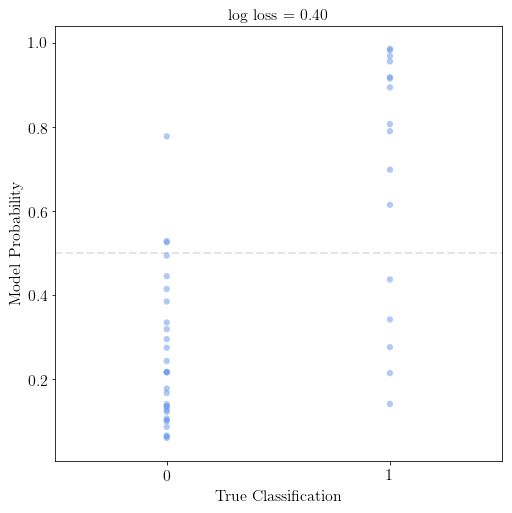

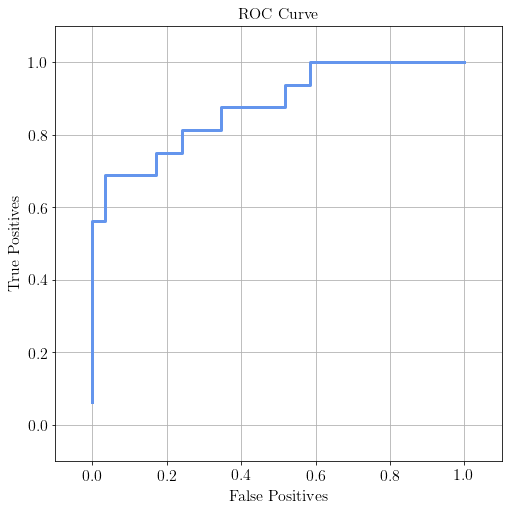

In [6]:
from sklearn.metrics import roc_curve
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=16, usetex=True)


def plot_results(labels, probs, thresh=0.5):
    plt.figure(figsize=(8,8))
    plt.scatter(labels, probs[:,1], edgecolor='none', c='cornflowerblue', s=40, alpha=0.5)
    plt.axhline(thresh, c='grey', alpha=0.2, lw=2, zorder=0, ls='--')
    plt.xlabel('True Classification')
    plt.ylabel('Model Probability')
    plt.title('log loss = %.2f'%log_loss(labels, probs))
    plt.xticks([0,1])
    plt.xlim(-0.5, 1.5)
    plt.show()
    
    fpr, tpr, thresh = roc_curve(labels2, probs[:,1])
    
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, 'cornflowerblue', lw=3)
    plt.xlabel('False Positives')
    plt.ylabel('True Positives')
    plt.title('ROC Curve')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.grid()
    plt.show()
    
model_svc = SVC(train1, labels1)
probs = model_svc.predict_proba(train2)
plot_results(labels2, probs)

# SVM with grid search CV

In [60]:
# After finetuning the grid
params = {'C':[0.15,0.016,0.17,0.18,0.19], 'gamma':[0.06,0.07,0.08,0.09,0.1],'coef0':[0.4,0.45,0.5,0.55,0.6,0.65,0.7]}

from sklearn import svm, metrics
SVC_class = svm.SVC(kernel='sigmoid', decision_function_shape='ovr', probability=True)

from sklearn.model_selection import GridSearchCV
SVC_gs = GridSearchCV(SVC_class, params, cv=10, return_train_score=True)
SVC_gs.fit(train, train_labels2)

print 'Best params: ', SVC_gs.best_params_
print 'Best accuracy: %.2f' %(SVC_gs.best_score_ * 100)

Best params:  {'C': 0.17, 'coef0': 0.6, 'gamma': 0.08}
Best accuracy: 85.56


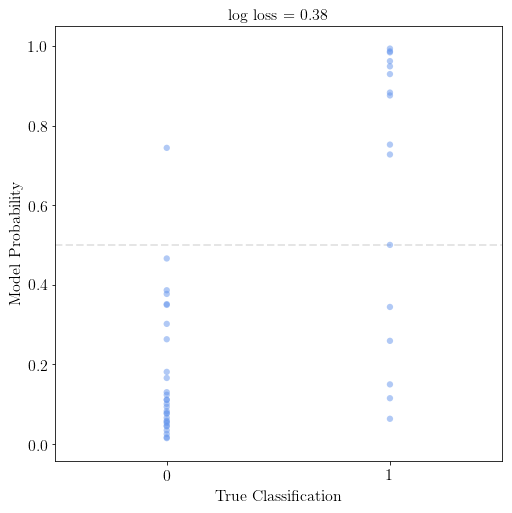

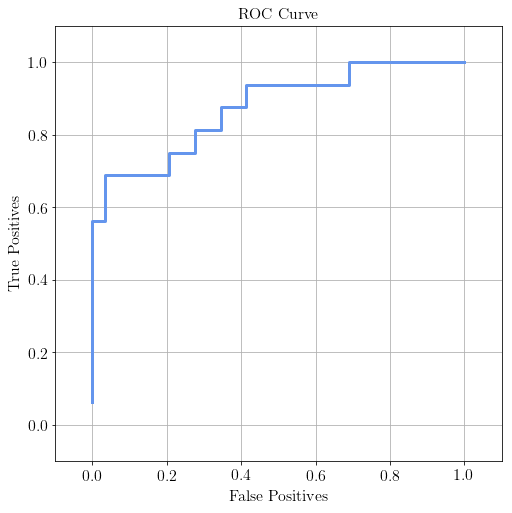

In [63]:
model_svc_gs = SVC(train1, labels1,C= 0.17, coef0= 0.6, gamma= 0.08, kernel='sigmoid', decision_function_shape='ovr')
probs_gs = model_svc_gs.predict_proba(train2)
plot_results(labels2, probs_gs)

In [62]:
best_SVC = SVC_gs.best_estimator_
prepare_submission(best_SVC, test, fname='SVC_jpoh_gs.csv')